In [79]:
import os
import cv2
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
device = torch.device("cpu")
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

from torchvision.ops import nms

model_path = '/mnt/EndorTeamArea/skulhare/sandbox/yolov7/runs/train/yolov7-tiny-ori-rotation/weights/best.pt'
updated_class_labels = ['out_of_focus_cervix', 'in_focus_cervix', 'non_cervix']
input_file_name = '/mnt/EndorTeamArea/skulhare/sandbox/dino_scripts/ave_images/iq/dataset/val/infocus/A12 AVE 030633 B.jpg'

#nms_pred = non_max_suppression(pred)#, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
#print(nms_pred)

In [80]:
# Define supporting functions
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.SiLU() if act is True else (act if isinstance(act, nn.Module) else nn.Identity())

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
        return self.act(self.conv(x))

class Ensemble(nn.ModuleList):
    # Ensemble of models
    def __init__(self):
        super(Ensemble, self).__init__()

    def forward(self, x, augment=False):
        y = []
        for module in self:
            y.append(module(x, augment)[0])
        # y = torch.stack(y).max(0)[0]  # max ensemble
        # y = torch.stack(y).mean(0)  # mean ensemble
        y = torch.cat(y, 1)  # nms ensemble
        return y, None  # inference, train output
    
def attempt_load(weights, map_location=None):
    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
    model = Ensemble()
    for w in weights if isinstance(weights, list) else [weights]:
        ckpt = torch.load(w, map_location=map_location)  # load
        model.append(ckpt['ema' if ckpt.get('ema') else 'model'].float().fuse().eval())  # FP32 model
    
    # Compatibility updates
    for m in model.modules():
        if type(m) in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True  # pytorch 1.7.0 compatibility
        elif type(m) is nn.Upsample:
            m.recompute_scale_factor = None  # torch 1.11.0 compatibility
        elif type(m) is Conv:
            m._non_persistent_buffers_set = set()  # pytorch 1.6.0 compatibility
    
    if len(model) == 1:
        return model[-1]  # return model
    else:
        print('Ensemble created with %s\n' % weights)
        for k in ['names', 'stride']:
            setattr(model, k, getattr(model[-1], k))
        return model  # return ensemble


In [81]:
image_data = cv2.imread(input_file_name) 
image_data = image_data[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x41
image_data = np.expand_dims(image_data, axis=0) 
image_data = np.ascontiguousarray(image_data)

# Convert images from numpy array to torch tensor.
image_data = torch.from_numpy(image_data)
image_data = image_data.float()  # uint8 to fp16/32
image_data /= 255.0  # 0 - 255 to 0.0 - 1.0

image_data = image_data.to(device)
model = attempt_load(model_path)
model.to(device)
pred = model(image_data)

num_classes = pred[0].shape[2] - 5
print("Number of Classes " , num_classes)

#print(len(pred[0])) # pred[0] : Tensor of size [1, 9072, 7]
# print(len(pred[1])) # len = 3 

pre_nms_boxes_conf = pred[0][0][:, 5:] * pred[0][0][:, 4:5]
pre_nms_boxes = xywh2xyxy(pred[0][0][:, :4])

 # pred[1] is a list with 3 item each of length 5
# print(pred[1][1][0].shape) = torch.Size([3, 24, 24, 7])
# print(pred[1][0][0].shape) = torch.Size([3, 48, 48, 7])
# print(pred[1][2][0].shape) = torch.Size([3, 12, 12, 7])


Fusing layers... 
IDetect.fuse
Number of Classes  2


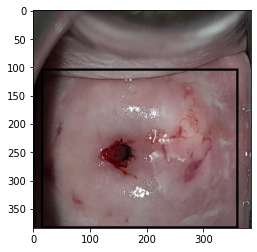

In [83]:
%matplotlib inline

post_nms_boxes = nms(pre_nms_boxes, scores=pre_nms_boxes_conf[:,0], iou_threshold=0.30)

# Get top 10 post nms boxes
post_nms_top_10_boxes = pre_nms_boxes[post_nms_boxes[0:10]]
img_with_bboxes = draw_bounding_boxes((image_data[0,:,:,:] * 255).to(torch.uint8), post_nms_top_10_boxes, width=4)

img_with_bboxes = img_with_bboxes.permute(1,2,0).numpy()
plt.imshow(img_with_bboxes)
plt.show()
  